**DDL Diagram**

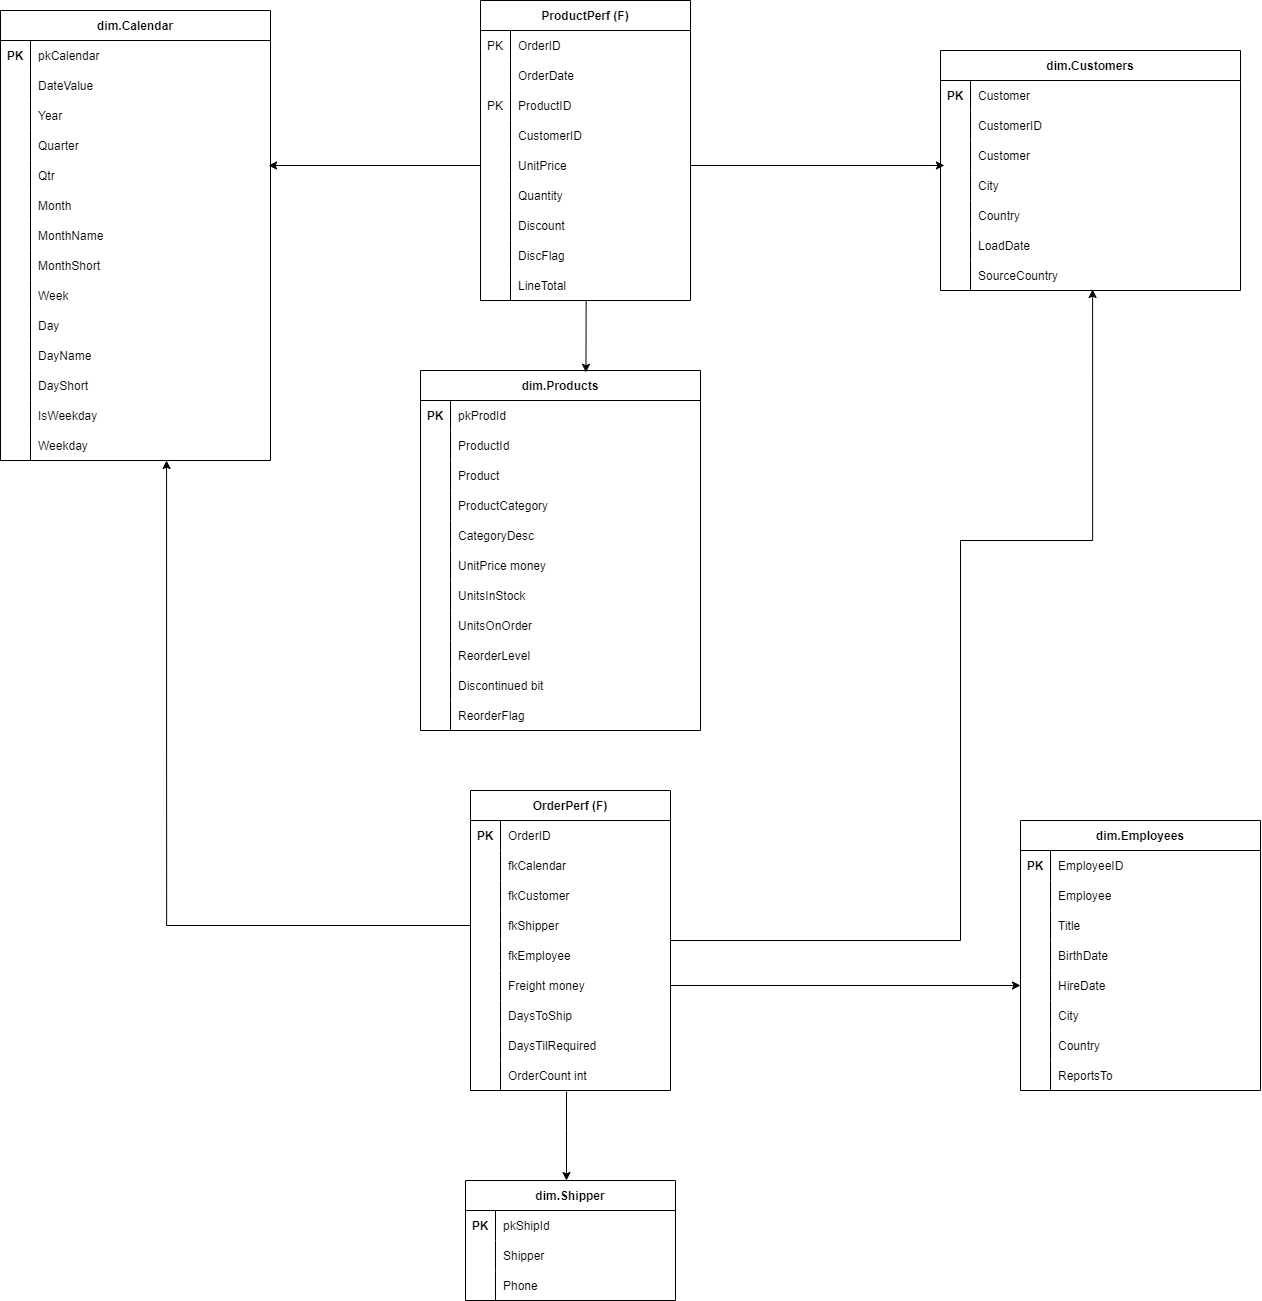

**\# Data Mart Creation and Data Loading**

\## DDL (Table Builds)

\### Schema Creation

**Explanation: Creating the required schemas for dimensions and facts.**

In [19]:
  

-- SQL code for creating schemas

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'dim')
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA dim AUTHORIZATION dbo;';
END;

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'stg')
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA stg AUTHORIZATION dbo;';
END;

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'f')
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA f AUTHORIZATION dbo;';
END;


Commands completed successfully.

Total execution time: 00:00:00.009

**Customer Dimension Table**

**\*\*Explanation:\*\***

**Creating the Customer dimension table.**

In [20]:
-- SQL code for creating dim.Customers table

IF NOT EXISTS (SELECT 1 FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Customers')
BEGIN
    CREATE TABLE dim.Customers (
        pkCustomer int IDENTITY(1000,1) NOT NULL,
        CustomerID nvarchar(5) NOT NULL,
        Customer nvarchar(40) NOT NULL,
        City nvarchar(15) NULL,
        Country nvarchar(15) NULL,
        LoadDate DATE NOT NULL,
        SourceCountry nvarchar(25) NULL
    );

    -- Add constraints
    ALTER TABLE dim.Customers
    ADD CONSTRAINT PK_Customers_LUP PRIMARY KEY(pkCustomer);

    ALTER TABLE dim.Customers
    ADD CONSTRAINT UC_Customers_ID UNIQUE (CustomerID);
END


Commands completed successfully.

Total execution time: 00:00:00.025

**Employee Dimension Table**

In [21]:
-- SQL code for creating dim.Employees table

IF NOT EXISTS (SELECT 1 FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Employees')
BEGIN
    CREATE TABLE dim.Employees (
        EmployeeID int IDENTITY(1000,1) NOT NULL,
        Employee nvarchar(40) NOT NULL,
        Title nvarchar(50) NULL,
        BirthDate DATE NULL,
        HireDate DATE NULL,
        City nvarchar(15) NULL,
        Country nvarchar(15) NULL,
        ReportsTo int NULL -- Assuming ReportsTo is a foreign key referencing EmployeeID
    );

    -- Add constraints
    ALTER TABLE dim.Employees
    ADD CONSTRAINT PK_Employees PRIMARY KEY (EmployeeID);
    
    -- Assuming ReportsTo is a foreign key referencing EmployeeID
    ALTER TABLE dim.Employees
    ADD CONSTRAINT FK_Employees_ReportsTo
        FOREIGN KEY (ReportsTo)
        REFERENCES dim.Employees(EmployeeID);
END


Commands completed successfully.

Total execution time: 00:00:00.012

**Calendar Dimension Table**  
<span style="white-space-collapse: preserve; color: rgb(55, 65, 81); font-family: Söhne, ui-sans-serif, system-ui, -apple-system, &quot;Segoe UI&quot;, Roboto, Ubuntu, Cantarell, &quot;Noto Sans&quot;, sans-serif, &quot;Helvetica Neue&quot;, Arial, &quot;Apple Color Emoji&quot;, &quot;Segoe UI Emoji&quot;, &quot;Segoe UI Symbol&quot;, &quot;Noto Color Emoji&quot;; font-size: 16px;"><b>Explanation: Creating the Calendar dimension table.</b></span>

In [22]:
-- SQL code for creating dim.Calendar table

IF NOT EXISTS (SELECT 1 FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Calendar')
BEGIN
    CREATE TABLE dim.Calendar
    (
        pkCalendar INT NOT NULL,
        DateValue DATE NOT NULL,
        Year INT NOT NULL,
        Quarter INT NOT NULL,
        Qtr VARCHAR(3) NOT NULL,
        Month INT NOT NULL,
        MonthName VARCHAR(10) NOT NULL,
        MonthShort VARCHAR(3) NOT NULL,
        Week INT NOT NULL,
        Day INT NOT NULL,
        DayName VARCHAR(10) NOT NULL,
        DayShort VARCHAR(3) NOT NULL,
        IsWeekday BIT NOT NULL,
        Weekday VARCHAR(3) NOT NULL
    );

    -- Add constraints
    ALTER TABLE dim.Calendar
    ADD CONSTRAINT PK_Calendar_Julian PRIMARY KEY (pkCalendar);

    ALTER TABLE dim.Calendar
    ADD CONSTRAINT UC_Calendar UNIQUE (DateValue);
END


Commands completed successfully.

Total execution time: 00:00:00.011

**\*\*Shipper Dimension Table**

**Explanation:- Creating the shipper dimension table.\*\***

In [23]:
-- SQL code for creating dim.Shipper table

IF NOT EXISTS (SELECT 1 FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Shipper')
BEGIN
    CREATE TABLE dim.Shipper
    (
        pkShipId int not null,
        Shipper nvarchar(40) not null,
        Phone nvarchar(24) null
    );

    -- Add constraints
    ALTER TABLE dim.Shipper
    ADD CONSTRAINT PK_Ship PRIMARY KEY(pkShipId);
END


Commands completed successfully.

Total execution time: 00:00:00.010

**OrderPerf Fact Table**

**Explanation- Creating the OrderPerf fact table.**

In [24]:
-- SQL code for creating f.OrderPerf table


    ALTER TABLE f.OrderPerf
DROP CONSTRAINT FK_ORDtoEMP;
IF EXISTS (SELECT 1 FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'f' AND TABLE_NAME = 'OrderPerf')
BEGIN
    DROP TABLE f.OrderPerf;
END

CREATE TABLE f.OrderPerf(
    OrderID int NOT NULL,
    fkCalendar int NOT NULL,
    fkCustomer int NOT NULL,
    fkShipper int NULL,
    fkEmployee int NULL,
    Freight money NOT NULL,
    DaysToShip int NULL,
    DaysTilRequired int NULL,
    OrderCount int NOT NULL
);

-- Add constraints

ALTER TABLE f.OrderPerf
ADD CONSTRAINT PK_ORD PRIMARY KEY(OrderID);

ALTER TABLE f.OrderPerf
ADD CONSTRAINT FK_ORDtoCAL
    FOREIGN KEY (fkCalendar)        
    REFERENCES dim.Calendar(pkCalendar);

ALTER TABLE f.OrderPerf
ADD CONSTRAINT FK_ORDtoCUST
    FOREIGN KEY (fkCustomer)        
    REFERENCES dim.Customers(pkCustomer);

ALTER TABLE f.OrderPerf
ADD CONSTRAINT FK_ORDtoSHIP
    FOREIGN KEY (fkShipper)
    REFERENCES dim.Shipper(pkShipId);

ALTER TABLE f.OrderPerf
ADD CONSTRAINT FK_ORDtoEMP
    FOREIGN KEY (fkEmployee)
    REFERENCES dim.Employees(EmployeeID);




Commands completed successfully.

Total execution time: 00:00:00.036

# **DATA LOADING SCRIPT**

**Loading Data Into dim.Customers**

**Explanation- Loading data into the customer dimension table.**

In [25]:
-- SQL code for loading data into dim.Customers

INSERT INTO dim.Customers (CustomerID, Customer, City, Country, LoadDate, SourceCountry)
SELECT nwc.CustomerID, nwc.CompanyName, nwc.City, nwc.Country, CAST(GETDATE() AS DATE), CONCAT('Country = ', nwc.Country)
FROM [Northwind_2023].[dbo].[Customers] nwc
WHERE nwc.CustomerID NOT IN (SELECT CustomerID FROM dim.Customers);


(0 rows affected)

Total execution time: 00:00:00.009

**Loading Data into dim.Calendar**  
**Explanation- Loading data into the Customer dimension table.**

In [26]:
IF (SELECT count(*) FROM dim.Calendar) = 0
BEGIN
-- Declare variables
DECLARE @StartDate DATE = '2020-01-01'
DECLARE @EndDate DATE = DATEADD(year, 0, GETDATE())
DECLARE @Date DATE = @StartDate
DECLARE @DayID INT = (datepart(year, @StartDate)-1900)*1000 + datepart(dy, @StartDate)
;


-- Populate the Calendar table
WHILE @Date <= @EndDate
	BEGIN
		INSERT INTO dim.Calendar (pkCalendar, DateValue, Year, Quarter, Qtr, Month,  MonthName, MonthShort, Week, Day, DayName, DayShort, IsWeekday, Weekday)
		VALUES (
			@DayID,
			@Date,
			YEAR(@Date),
			DATEPART(QUARTER, @Date),
			CASE WHEN DATEPART(QUARTER, @Date) IN (1) THEN '1st'
				 WHEN DATEPART(QUARTER, @Date) IN (2) THEN '2nd'
				 WHEN DATEPART(QUARTER, @Date) IN (3) THEN '3rd'
				 WHEN DATEPART(QUARTER, @Date) IN (4) THEN '4th'
				 ELSE '5th'
				 END,
			MONTH(@Date),
			DATENAME(MONTH, @Date),
			LEFT(DATENAME(MONTH, @Date),3),
			DATEPART(WEEK, @Date),
			DAY(@Date),
			DATENAME(WEEKDAY, @Date),
			LEFT(DATENAME(WEEKDAY, @Date),3),
			CASE WHEN DATEPART(WEEKDAY, @Date) IN (1, 7) THEN 0 ELSE 1 END, -- Set IsWeekday to 0 for Saturday (1) and Sunday (7), and 1 for weekdays
			CASE WHEN DATEPART(WEEKDAY, @Date) IN (1, 7) THEN 'No' ELSE 'Yes' END
	 )

		-- Increment the date and day ID
		SET @Date = DATEADD(DAY, 1, @Date)
		SET @DayID = @DayID + 1
	END
END
GO

Commands completed successfully.

Total execution time: 00:00:00.002